In [1]:
# import -- > libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import joblib
pd.set_option('display.max_columns', None)





# Sklearn --> Preprocessing 

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler , OrdinalEncoder , OneHotEncoder
from sklearn.pipeline import Pipeline , FeatureUnion
from sklearn_features.transformers import DataFrameSelector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

# Sklearn --> Models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor






# Slearn --> metrics
from sklearn.metrics import r2_score

# Slearn --> Tuning
from sklearn.model_selection import GridSearchCV

In [2]:
# Reading data
df = pd.read_csv('Salary_Data.csv')
df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


In [3]:
# Check Shape
df.shape

(6704, 6)

In [4]:
#Checking data type of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6704 entries, 0 to 6703
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  6702 non-null   float64
 1   Gender               6702 non-null   object 
 2   Education Level      6701 non-null   object 
 3   Job Title            6702 non-null   object 
 4   Years of Experience  6701 non-null   float64
 5   Salary               6699 non-null   float64
dtypes: float64(3), object(3)
memory usage: 314.4+ KB


In [5]:
# check NAN values
df.isna().sum()

Age                    2
Gender                 2
Education Level        3
Job Title              2
Years of Experience    3
Salary                 5
dtype: int64

In [6]:
# Drop NAN values
df.dropna(axis=0,inplace=True)

In [7]:
df.select_dtypes(include='number').describe().T

,count,mean,std,min,25%,50%,75%,max
Age,6698.0,33.623022,7.615784,21.0,28.0,32.0,38.0,62.0
Years of Experience,6698.0,8.095178,6.060291,0.0,3.0,7.0,12.0,34.0
Salary,6698.0,115329.253061,52789.792507,350.0,70000.0,115000.0,160000.0,250000.0


In [8]:
df.select_dtypes(include='object').describe().T

,count,unique,top,freq
Gender,6698,3,Male,3671
Education Level,6698,7,Bachelor's Degree,2265
Job Title,6698,191,Software Engineer,518


In [9]:
# Rename columns
df.columns = ['Age', 'Gender', 'Education', 'Title', 'Experience', 'Salary']

In [10]:
df.columns

Index(['Age', 'Gender', 'Education', 'Title', 'Experience', 'Salary'], dtype='object')

In [11]:
# Function to Make Grouping Job Titles
def categorize_jop_title(value):
    value = str(value).lower()
    if 'software' in value or 'developer' in value:
        return 'Software/Developer'
    elif 'data' in value or 'analyst' in value or 'scientist' in value:
        return 'Data Analyst/scientist'
    elif 'manager' in value or 'director' in value or 'vp' in value:
        return 'Manager/Director/VP'
    elif 'sales' in value or 'representative' in value:
        return 'Sales'
    elif 'marketing' in value or 'social media' in value:
        return 'Marketing/Social Media'
    elif 'product' in value or 'designer' in value:
        return 'Product/Designer'
    elif 'hr' in value or 'human resources' in value:
        return 'HR/Human Resources'
    elif 'financial' in value or 'accountant' in value:
        return 'Financial/Accountant'
    elif 'project manager' in value :
        return 'Project Manager'
    elif 'it' in value or 'support' in value :
        return 'IT/Technical Support'
    elif 'operations' in value or 'supply chain' in value:
        return 'Operations/Supply Chain'
    elif 'customer service' in value or 'receptionist':
        return 'Customer Service/Receptionist'
    else:
        return 'Other'

df['Title'] = df['Title'].apply(categorize_jop_title)

In [12]:
# Education Level is Represented in two Different ways : Bachelor's & Bachelor's Degree
# Which Meanssame , So I will Make Gouping to it
df['Education'].unique()

array(["Bachelor's", "Master's", 'PhD', "Bachelor's Degree",
       "Master's Degree", 'High School', 'phD'], dtype=object)

In [13]:
# Function to make Grouping Education Level
def group_education(value):
    value = str(value).lower()
    if 'high school' in value:
        return 'High School'
    elif 'bachelor\'s' in value or 'bachelor\'s degree' in value:
        return 'Bachelors'
    elif 'master\'s' in value or 'master\'s degree'  in value:
        return 'Masters'
    elif 'phd' in value :
        return 'PHD'
    
df['Education'] = df['Education'].apply(group_education)

In [14]:
df['Experience'].unique()

array([ 5. ,  3. , 15. ,  7. , 20. ,  2. , 12. ,  4. ,  1. , 10. , 18. ,
        6. , 14. , 16. ,  0. , 22. , 19. ,  9. , 13. , 11. , 25. , 21. ,
        8. , 17. , 23. , 24. ,  0.5,  1.5, 31. , 30. , 28. , 33. , 27. ,
       34. , 29. , 26. , 32. ])

In [15]:
# Extract featuer called Positions based on Years of Experience
def positions(value):
    try:
        if value <= 5:
            return  "Junior"
        elif value <= 10:
            return "Senior"
        elif value <= 15:
            return  "Team Leader"
        else:
            return 'Manager'
    except:
        np.nan

df['Positions']  = df['Experience'].apply(positions)

# EDA

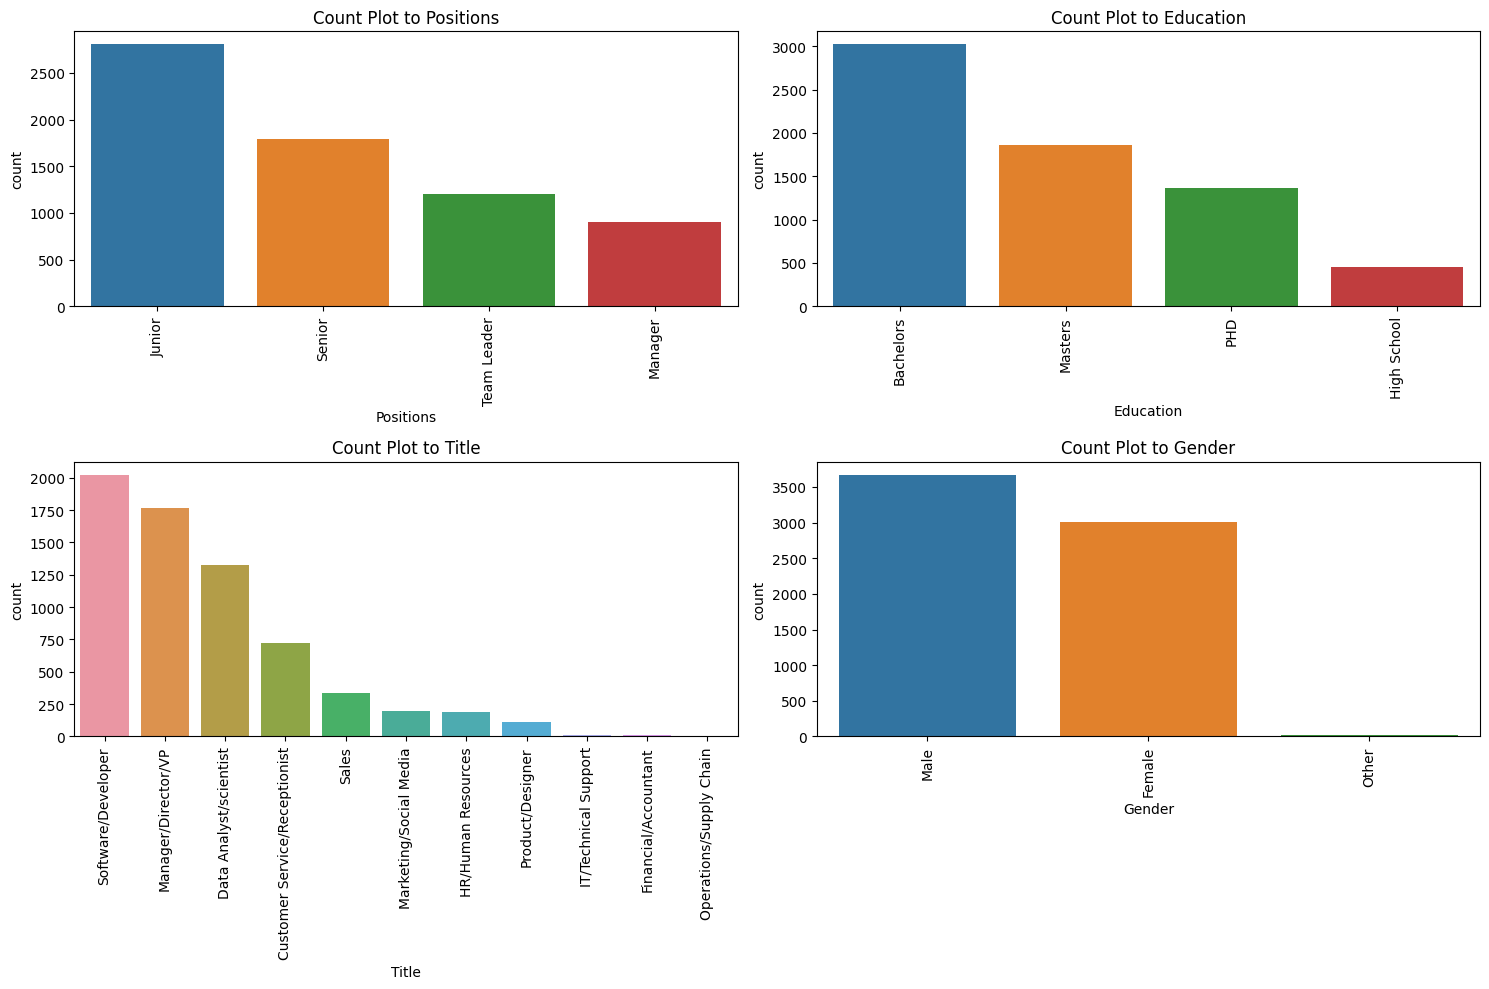

In [16]:
# distribution of a categorical variable 
cat_var = ['Positions' , 'Education' , 'Title' , 'Gender']
fig , axs = plt.subplots(nrows=2 , ncols=2 , figsize = (15 , 10))
axs = axs.flatten()
for i , var in enumerate(cat_var):
    sns.countplot(data=df , x = var , ax = axs[i] , order= df[var].value_counts().index)
    axs[i].set_xticklabels(axs[i].get_xticklabels() , rotation = 90)
    axs[i].set_title(f"Count Plot to {var}")
    
fig.tight_layout()



plt.show()

In [17]:
# minimum and maximum age values for each unique position in the 
df[['Positions' , 'Age']].groupby('Positions')['Age'].agg(['min','max']).T

Positions,Junior,Manager,Senior,Team Leader
min,21.0,38.0,26.0,25.0
max,36.0,62.0,45.0,54.0


In [18]:
# minimum and maximum Experience values for each unique position in the
df[['Positions' , 'Experience']].groupby('Positions')['Experience'].agg(['min','max']).T

Positions,Junior,Manager,Senior,Team Leader
min,0.0,16.0,6.0,11.0
max,5.0,34.0,10.0,15.0


<Axes: title={'center': 'the minimum salary for each Title'}, xlabel='Title'>

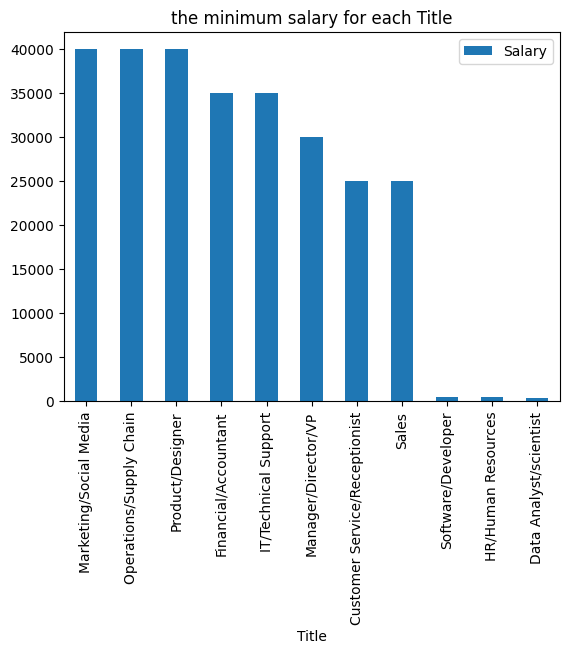

In [19]:
# the minimum salary for each Title
df[['Title' , 'Salary']].groupby('Title')[['Salary']].min().sort_values(by='Salary' , ascending = False).reset_index().plot(x='Title' , kind='bar' , title='the minimum salary for each Title')

<Axes: title={'center': 'the mean salary for each Title'}, xlabel='Title'>

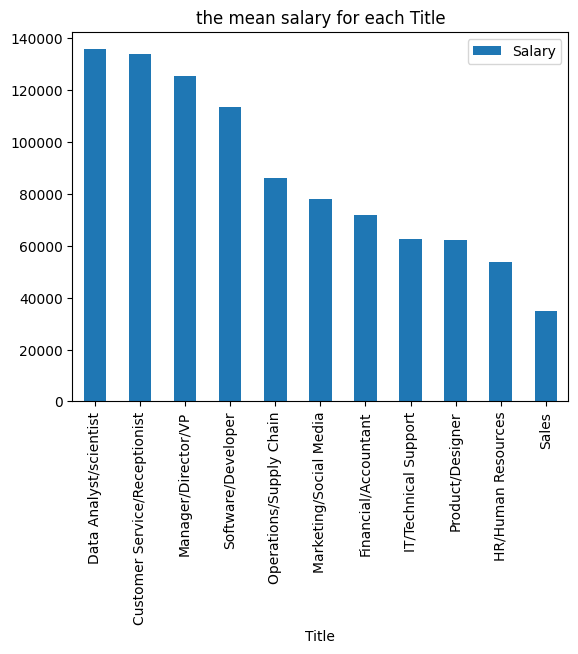

In [20]:
# the mean salary for each Title
df[['Title' , 'Salary']].groupby('Title')[['Salary']].mean().sort_values(by='Salary' , ascending = False).reset_index().plot(x='Title' , kind='bar' , title='the mean salary for each Title')

<Axes: title={'center': 'the highest salary for each Title'}, xlabel='Title'>

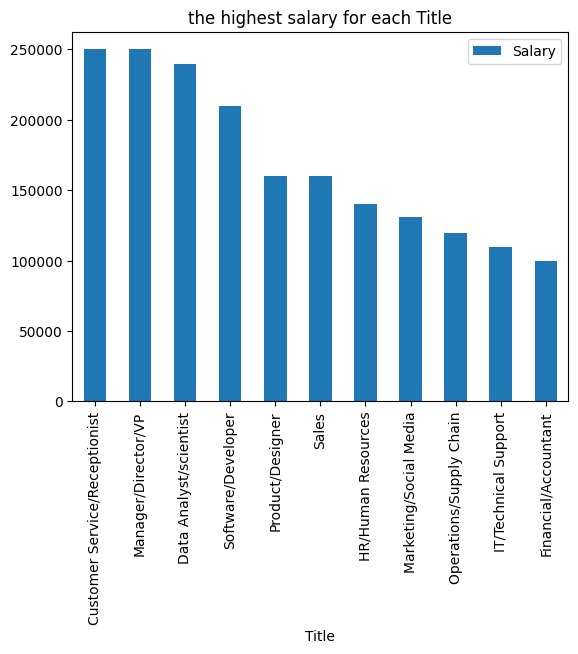

In [21]:
# highest salary for each Title
df[['Title' , 'Salary']].groupby('Title')[['Salary']].max().sort_values(by='Salary' , ascending = False).reset_index().plot(x='Title' , kind='bar' , title='the highest salary for each Title')

In [22]:
# Gender Distribution for each position
px.histogram(data_frame=df , x = 'Positions' , color='Gender' , barmode='group' , title= 'Gender Distribution by Position')

In [23]:
# Gender Distribution for each Education Level
px.histogram(data_frame=df , x = 'Education' , color='Gender' , barmode='group' , title= 'Gender Distribution by Education Level')

In [24]:
# Gender Distribution for each title
px.histogram(data_frame=df , x = 'Title' , color='Gender' , barmode='group' , title= 'Gender Distribution by Title')

In [45]:
px.histogram(data_frame=df , x = 'Positions' , color='Gender' , barmode='group' , title= 'Gender Distribution by Title')

In [25]:
# Education Distribution for each title 
px.histogram(data_frame=df , x = 'Title' , color='Education' , barmode='group' , title= 'Education Distribution by Title')

In [26]:
# Gender  Distribution for each Education for each Positions
sunb = df[['Gender' , 'Education' , 'Positions']]
px.sunburst(data_frame = sunb ,
            path= ['Gender' , 'Education' , 'Positions' ] , height=700 , title= 'Sunburst Chart: Gender, Education, and Positions Hierarchy')

In [27]:
px.scatter(data_frame=df , x = 'Salary' , y = 'Experience' , size='Age' , size_max=20 , hover_name = 'Positions' , color='Positions' ,
           title= 'Salary, Experience, and Age Relationship by Positions', animation_frame='Age', range_y=(0, 60) , height=700)

<Axes: >

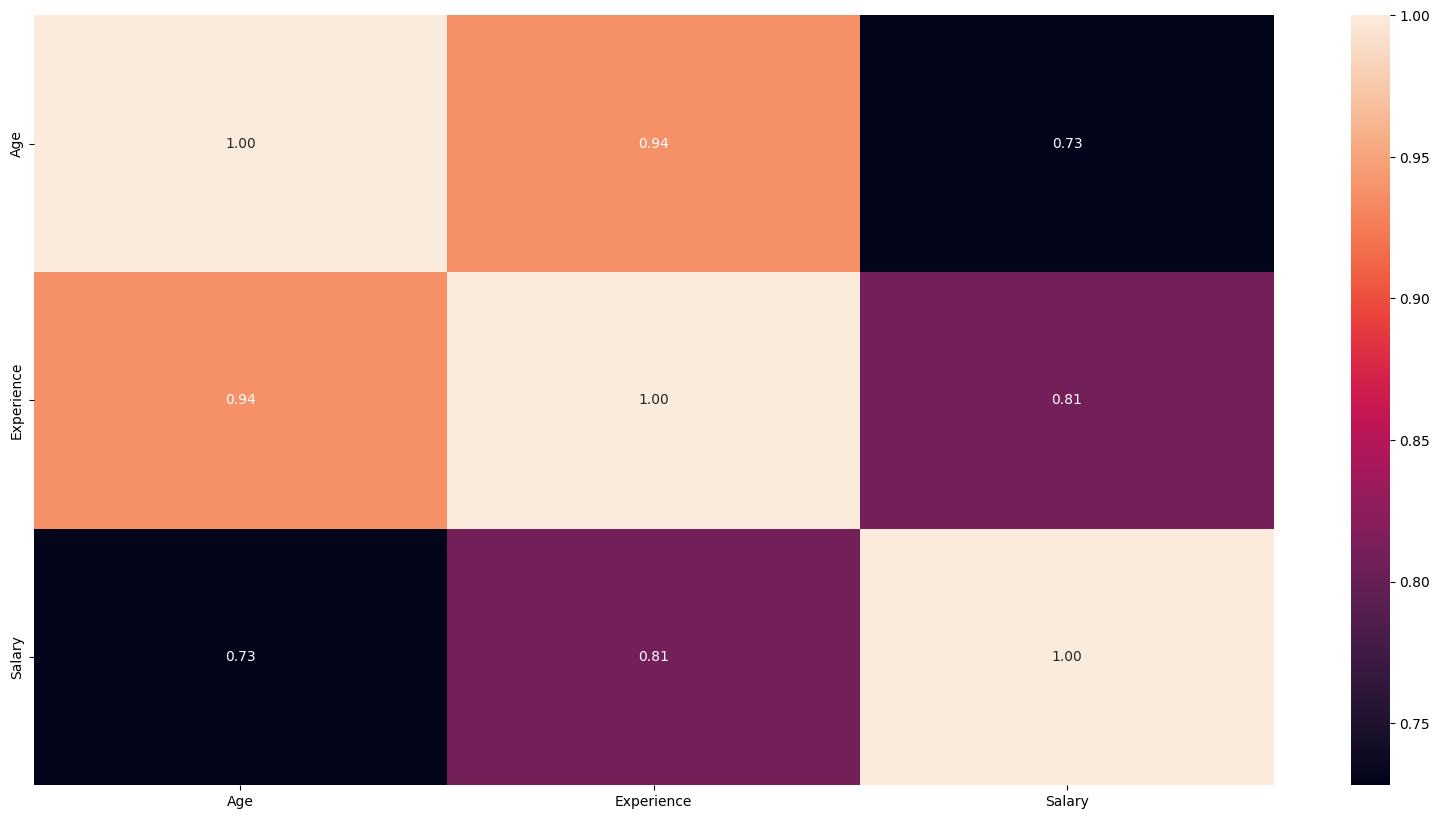

In [28]:
# Correlation Heatmap (print the correlation score each variables)
df_num = df.select_dtypes(include='number')
plt.figure(figsize= (20 , 10))
sns.heatmap(df_num.corr() , fmt = '.2f' , annot = True)

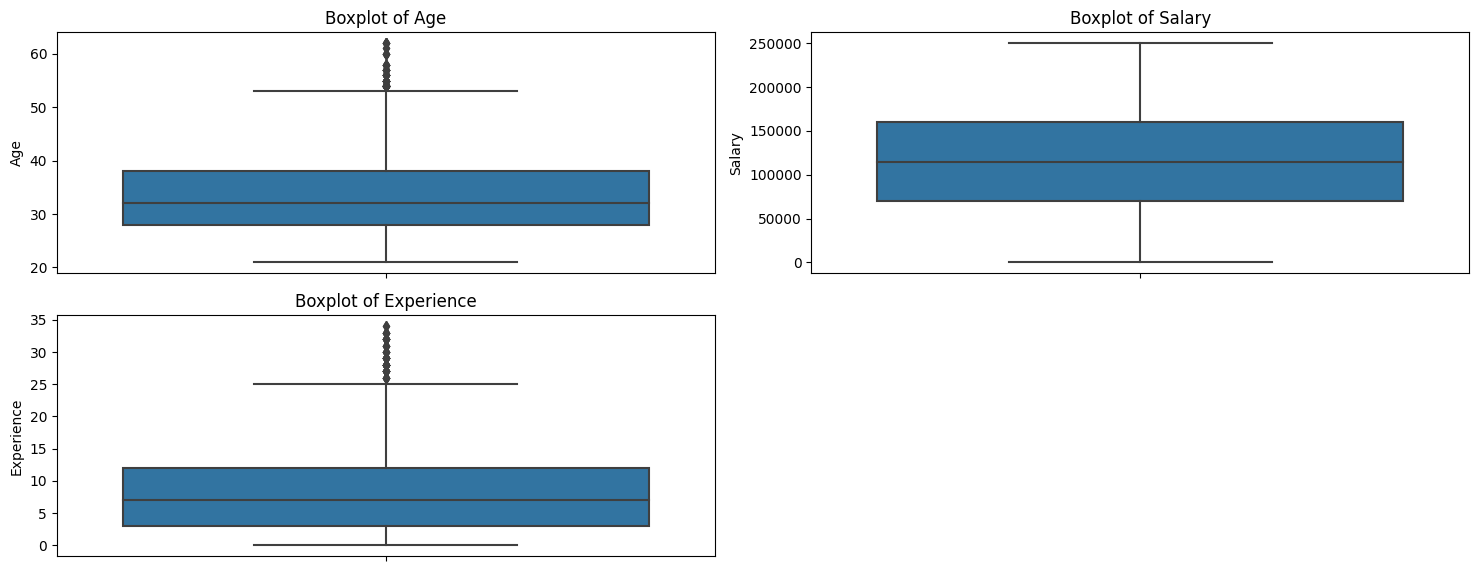

In [29]:
# Boxplot to detect outlier
num_var = ['Age' , 'Salary' , 'Experience']
fig , axs = plt.subplots(nrows= 2 , ncols = 2 , figsize = (15 , 6))
axs = axs.flatten()

for i , var in enumerate(num_var):
    sns.boxplot(data=df , y = var , ax = axs[i]   )
    
    
    axs[i].set_title(f"Boxplot of {var}")


fig.tight_layout()

fig.delaxes(axs[3])

plt.show()

In [30]:
df['Age'].unique()

array([32., 28., 45., 36., 52., 29., 42., 31., 26., 38., 48., 35., 40.,
       27., 44., 33., 39., 25., 51., 34., 47., 30., 41., 37., 24., 43.,
       50., 46., 49., 23., 53., 61., 57., 62., 55., 56., 54., 60., 58.,
       22., 21.])

# Spliting

In [31]:
# Split to features and target 
X = df.drop(columns = 'Salary' , axis = 1)
y = df['Salary']

In [32]:
# Split to train and test 
X_train , X_test , y_train , y_test =  train_test_split(X , y , test_size = 0.2 , shuffle = True , random_state = 45 )

print('X_train.shap ' , X_train.shape)
print('y_train.shap ' , y_train.shape)
print('X_test.shap ' , X_test.shape)
print('y_test.shap ' , y_test.shape)

X_train.shap  (5358, 6)
y_train.shap  (5358,)
X_test.shap  (1340, 6)
y_test.shap  (1340,)


In [33]:
normal_cat = ['Gender', 'Education']
special_ord = ['Positions']
numerical = ['Age', 'Experience']
one_hot = ['Title']

In [34]:
#Numerical --> Impute median, RobustScaler
numerical_pip = Pipeline(steps=[
    ('Selector', DataFrameSelector(numerical)),
    ('imputer', SimpleImputer(strategy='median')),
    ('Scaling', RobustScaler())
])

# Category OrdinalEncoder -- > Impute most_frequent, encoding
normal_category_pip = Pipeline(steps=[
    ('Selector', DataFrameSelector(normal_cat)),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoding', OrdinalEncoder())
])

Positions_lis = [['Junior', 'Senior', 'Team Leader', 'Manager']]
special_ord_pip = Pipeline(steps=[
    ('Selector', DataFrameSelector(special_ord)),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoding', OrdinalEncoder(categories=Positions_lis))
])

# Category OneHotEncoder -- > Impute most_frequent, encoding
one_hot_pip = Pipeline(steps=[
                        ('Selector' , DataFrameSelector(one_hot)),
                       ('imputer' , SimpleImputer(strategy='most_frequent')),
                       ('incodeing' , OneHotEncoder(drop = 'first' , sparse=False ) )
])  

all_pip = FeatureUnion(transformer_list=[
    ('numerical_pip', numerical_pip),
    ('normal_category_pip', normal_category_pip),
    ('special_ord_pip', special_ord_pip),
    ('one_hot_pip', one_hot_pip)
])

X_train_final = all_pip.fit_transform(X_train)
X_test_final = all_pip.transform(X_test)

c:\Anaconda3\envs\final_project\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [35]:
# check shape after Piplien
X_train_final.shape , X_test_final.shape

((5358, 15), (1340, 15))

# Building Models

In [36]:
# Create folder called Models 
os.makedirs('Models' , exist_ok=True)

## KNN

In [37]:
KNN_reg = KNeighborsRegressor(n_neighbors = 5 , p = 2 , metric = 'minkowski')
KNN_reg.fit(X_train_final , y_train)

# predict 
y_pred_KNN_train =  KNN_reg.predict(X_train_final)
y_pred_KNN_test =  KNN_reg.predict(X_test_final)

#Evaluate
score_KNN_train = r2_score(y_train , y_pred_KNN_train)
score_KNN_test = r2_score(y_test , y_pred_KNN_test)

print(f'this R2_score of score_KNN_train {score_KNN_train * 100 : .3f}')
print(f'this R2_score of score_KNN_test {score_KNN_test * 100 : .3f}')


this R2_score of score_KNN_train  95.846
this R2_score of score_KNN_test  92.130


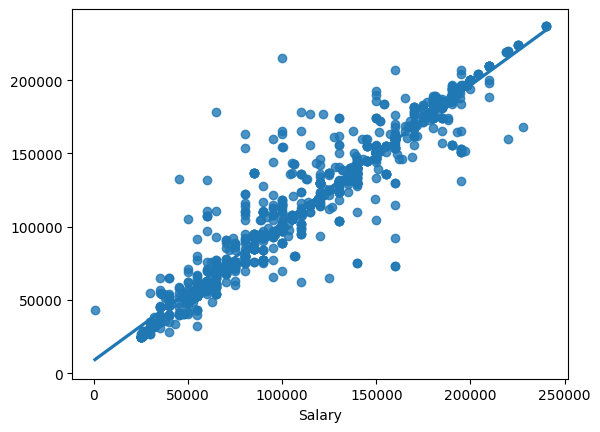

In [38]:
sns.regplot(x=y_test, y=y_pred_KNN_test)
plt.show()

## RandomForest

In [39]:
RF_reg =  RandomForestRegressor(n_estimators = 120 , max_depth = 150 ,
                                max_samples = 0.8 , random_state = 45 ,)
RF_reg.fit(X_train_final , y_train)

# predict 
y_pred_RF_train =  RF_reg.predict(X_train_final)
y_pred_RF_test =  RF_reg.predict(X_test_final)

#Evaluate
score_RF_train = r2_score(y_train , y_pred_RF_train)
score_RF_test = r2_score(y_test , y_pred_RF_test)

print(f'this R2_score of score_RF_train {score_RF_train * 100 :.3f}')
print(f'this R2_score of score_RF_test {score_RF_test * 100 :.3f}')


this R2_score of score_RF_train 97.744
this R2_score of score_RF_test 94.566


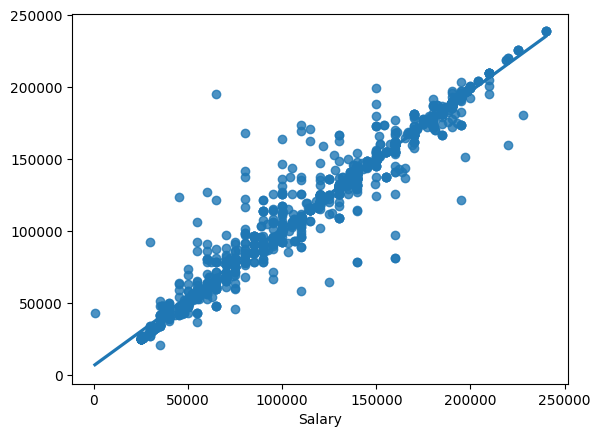

In [40]:
sns.regplot(x=y_test, y=y_pred_RF_test)
plt.show()

In [41]:
joblib.dump(RF_reg , 'Models/RF_reg.pkl')

['Models/RF_reg.pkl']

## XGBRegressor

In [42]:
xgb_reg =  XGBRegressor(objective = 'reg:squarederror' , learning_rate = 0.1 , 
            colsample_bytree = 0.8 , subsample = 0.8 , max_depth = 10 , n_estimators = 180)

xgb_reg.fit(X_train_final , y_train)

# predict 
y_pred_xgb_train =  xgb_reg.predict(X_train_final)
y_pred_xgb_test =  xgb_reg.predict(X_test_final)

#Evaluate
score_xgb_train = r2_score(y_train , y_pred_xgb_train)
score_xgb_test = r2_score(y_test , y_pred_xgb_test)

print(f'this R2_score of score_xgb_train {score_xgb_train * 100 :.3f}')
print(f'this R2_score of score_xgb_test {score_xgb_test * 100 :.3f}')


this R2_score of score_xgb_train 98.088
this R2_score of score_xgb_test 94.638


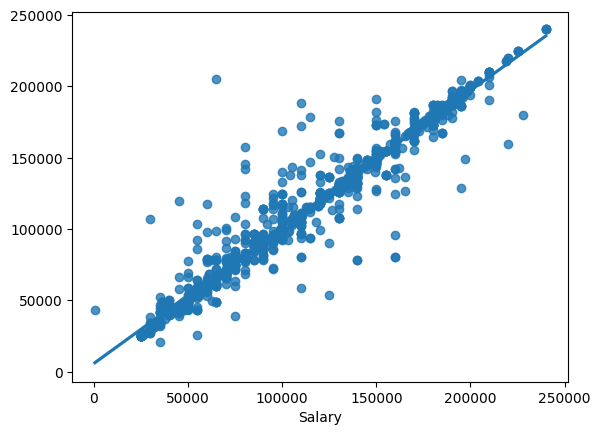

In [43]:
sns.regplot(x=y_test, y=y_pred_xgb_test)
plt.show()

In [44]:
# Make Dump to XGB 
joblib.dump(xgb_reg , 'Models/xgb_reg.pkl')

['Models/xgb_reg.pkl']